In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


In [2]:
!pip install scikit_posthocs

# Libraries and Utilities

In [3]:
import warnings
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import scipy.stats as stats
from scipy.stats import shapiro, normaltest
from scikit_posthocs import posthoc_dunn

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder,
                                   OneHotEncoder)
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier




In [4]:

# Ignore warnings
warnings.filterwarnings("ignore")

In [5]:
df_raw = pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
df_raw.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
#dropping the id column as we will be using the default index 
df_raw.drop("id",axis = 1, inplace = True)

# Data Preprocessing

In [7]:
df_raw.shape

(5110, 11)

In [8]:
df_raw.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


We can see from the above that there are some missing values in "bmi" column. Lets say how to handle this. 

Possible ways to handle missing value :

- Drop the rows with the missing value (bad because of data loss)
- Missing value imputation with a measure of central tendancy (easy and quick)
- Missing value imputation with a statistical/ML model (tedious sometimes but could be more effective)

Alternative : 
Dont handle it and use a model that can inherently handle missing values 

In [9]:
# how many missing values are there ?
print("No of Missing values in bmi column : ", df_raw['bmi'].isnull().sum())

No of Missing values in bmi column :  201


Ok, since I have plans to use linear models for baselining (stacking) and then build a neural network based final model, it kind of becomes necessary to handle the missing data. We will do this by building a machine learning model. But first lets see the distribution of this bmi.

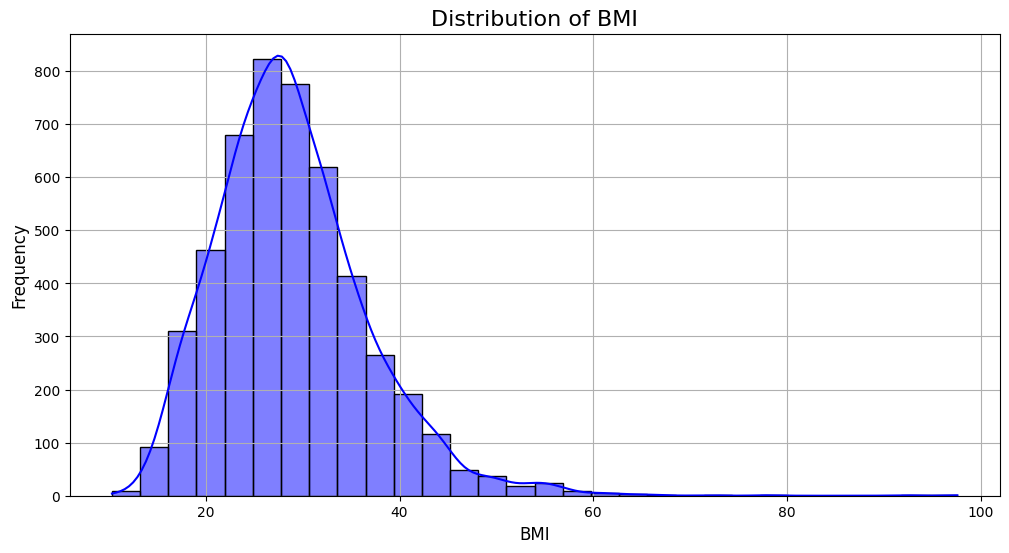

Shapiro-Wilk Test:
Statistic: nan, p-value: nan

D’Agostino and Pearson’s Test:
Statistic: nan, p-value: nan

The BMI values do not follow a normal distribution and may be skewed.


In [10]:

plt.figure(figsize=(12, 6))

# Histogram and KDE
sns.histplot(df_raw['bmi'], kde=True, color='blue', bins=30)
plt.title('Distribution of BMI', fontsize=16)
plt.xlabel('BMI', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

# Statistical analysis to check normality
print("Shapiro-Wilk Test:")
shapiro_test = shapiro(df_raw['bmi'])
print(f"Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4e}")

print("\nD’Agostino and Pearson’s Test:")
dagostino_test = normaltest(df_raw['bmi'])
print(f"Statistic: {dagostino_test.statistic:.4f}, p-value: {dagostino_test.pvalue:.4e}")

# Interpretation
if shapiro_test.pvalue > 0.05 and dagostino_test.pvalue > 0.05:
    print("\nThe BMI values appear to follow a normal distribution (Gaussian).")
else:
    print("\nThe BMI values do not follow a normal distribution and may be skewed.")


I really didnt need to do the shapiro-wilk test and all, its pretty evident from the distribution, that it is not exactly gaussian, but it is not too strongly skewed either. Hence maybe replacing by a measure of central tendency like mean, wont be too bad. But I want to go overboard and make it a model for imputation. We will use a decision tree model for now since that seems to have given other kaggleres the best results. Later we will try a KNN too.

In [11]:
# using the wonderful piece of code from Thomas Konstantin's Notebook 
DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])
X = df_raw[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df_raw.loc[Missing.index,'bmi'] = predicted_bmi

In [12]:
#checking if missing values are imputed
df_raw.bmi.isnull().sum()

0

# Extensive EDA

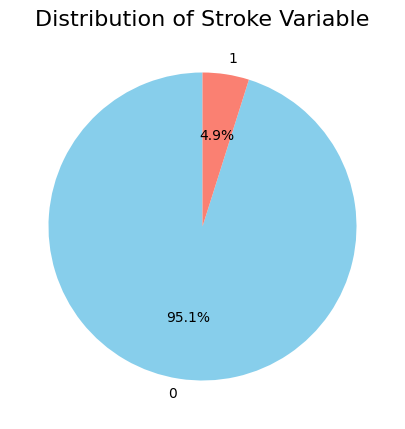

In [13]:
# lets explore the target variable "stroke"   
# Note - 1 represents stroke happening & 0 represents no Stroke


stroke_counts = df_raw["stroke"].value_counts()

plt.figure(figsize=(6, 5))
stroke_counts.plot.pie(autopct='%1.1f%%', startangle=90, labels=stroke_counts.index, colors=['skyblue', 'salmon'])
plt.title('Distribution of Stroke Variable', fontsize=16)
plt.ylabel('')  
plt.show()


As you can clearly see from the diagram, the target variable is highly skewed which basically directs me towards using SMOTE to resolve this issue. Lets see.

In [14]:
# Pulling out lists of all categorical and numerical variables for easier interpretation 

num_vars = ['age','avg_glucose_level','bmi']
cat_vars = [var for var in df_raw.columns if var not in ['stroke','id'] and var not in num_vars]

target = 'stroke'

print("Categorical Variables :", cat_vars)
print("Numerical Variables :", num_vars)
print("Target Variable :", target)

Categorical Variables : ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Numerical Variables : ['age', 'avg_glucose_level', 'bmi']
Target Variable : stroke


Lets look at the numerical variables first

## Bivariate Analysis

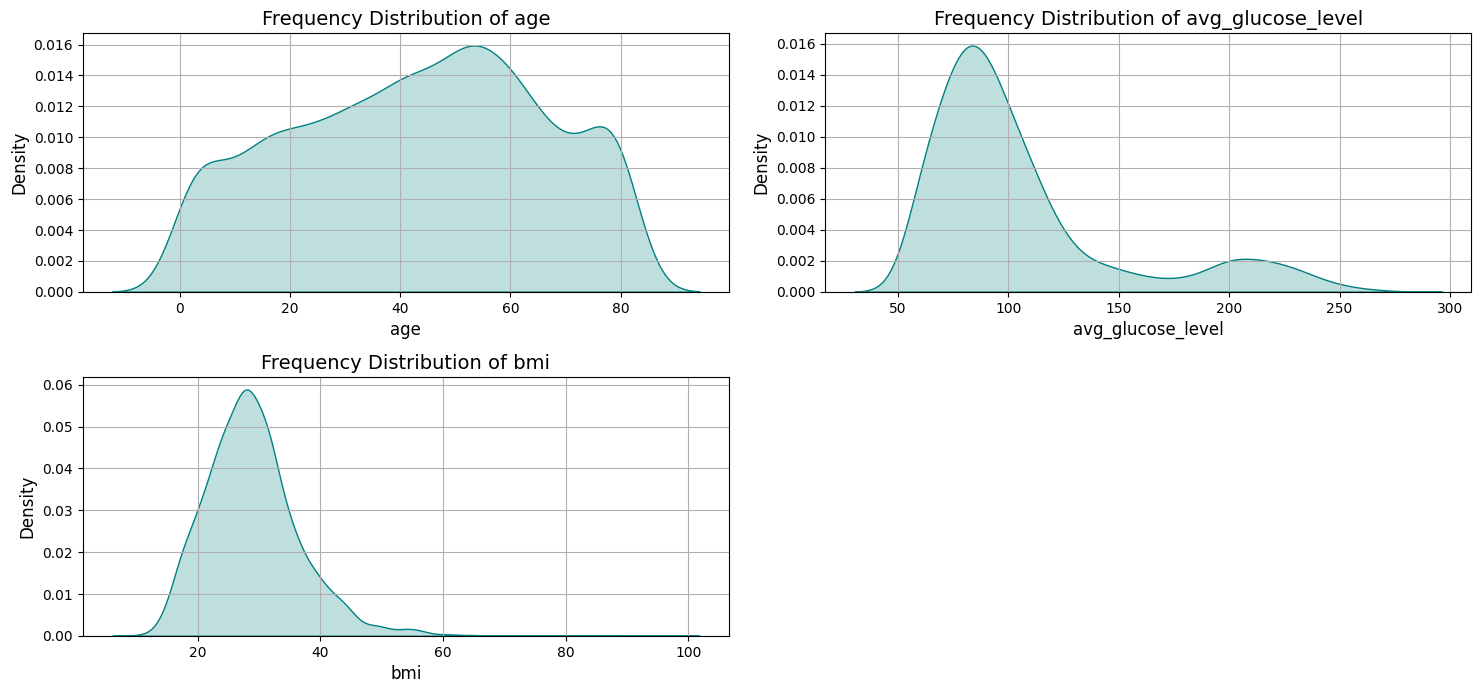

In [15]:
# Plot frequency distribution for each numerical variable
plt.figure(figsize=(15, 10))

for i, var in enumerate(num_vars, 1):
    plt.subplot(3, 2, i)  
    sns.kdeplot(data=df_raw[var], shade=True, color="teal")
    plt.title(f'Frequency Distribution of {var}', fontsize=14)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.grid(True)

plt.tight_layout()  

Looks like avg_glucose_level and bmi have positive skews

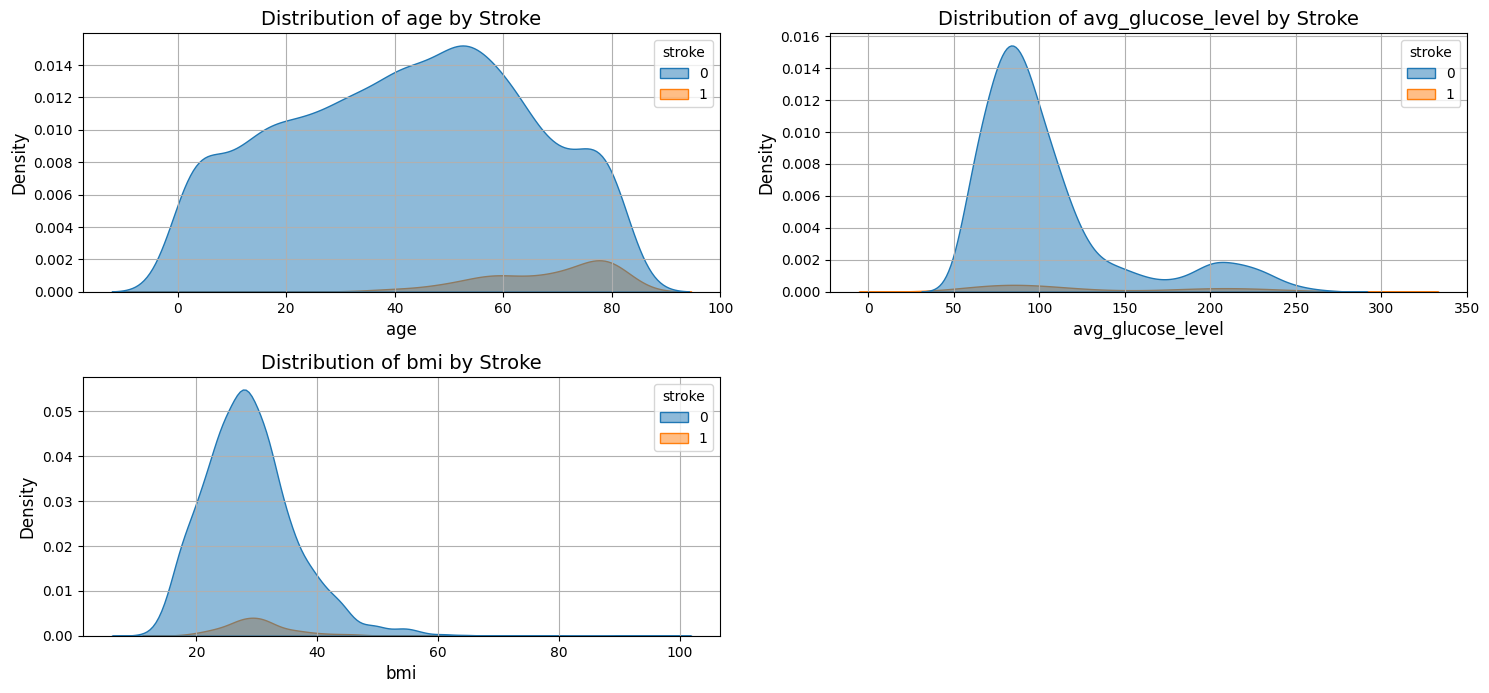

In [16]:
# Plot frequency distributions grouped by 'stroke'
plt.figure(figsize=(15, 10))

for i, var in enumerate(num_vars, 1):
    plt.subplot(3, 2, i)  # Create a grid of 3 rows and 2 columns
    sns.kdeplot(
        data=df_raw, x=var, hue='stroke', 
        shade=True, alpha=0.5
    )
    plt.title(f'Distribution of {var} by Stroke', fontsize=14)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

The above graphs give a good idea of the distrbution of numerical variables w.r.t the stroke variable. But since the data is highly skewed for stroke, hence its tough to get an idea. 
We will be plotting these graphs again below, but this time each group (i.e stroke =1 and stroke = 0) will be independently normalised and then plotted.

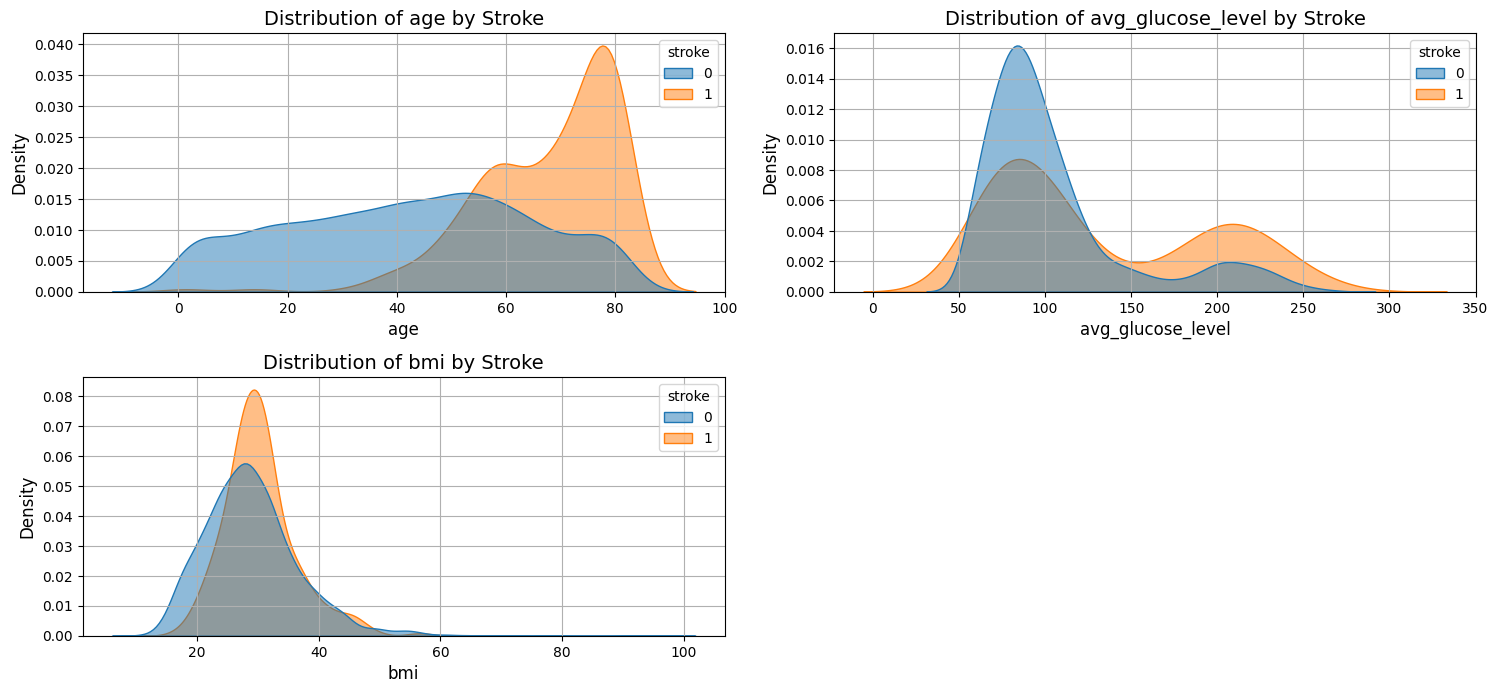

In [17]:
plt.figure(figsize=(15, 10))

for i, var in enumerate(num_vars, 1):
    plt.subplot(3, 2, i)  
    sns.kdeplot(
        data=df_raw, x=var, hue='stroke', 
        shade=True, alpha=0.5, common_norm=False
    )
    plt.title(f'Distribution of {var} by Stroke', fontsize=14)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.grid(True)

plt.tight_layout()  
plt.show()

Kind of telling us straight up that age is a very important factor for stroke prediction - since as age is increasing past 40 there is a sharp increase in positive strokes. We can really say much about the other 2 features as of now. 

Lets perform a quick correlation analysis to strengthen our beliefs

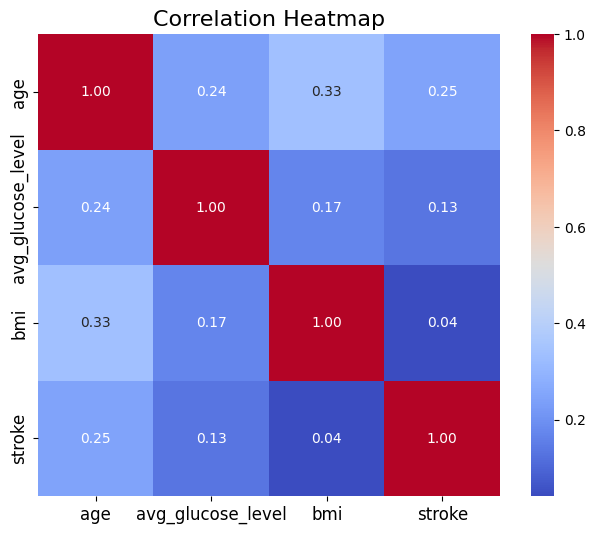

In [18]:
#plotting a correlation heatmap
corr_data = df_raw[['age', 'avg_glucose_level', 'bmi', 'stroke']]

correlation_matrix = corr_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

This is again proving that in comparison to bmi and avg_glucose_level, age happens to have a stronger postive correlation with stroke

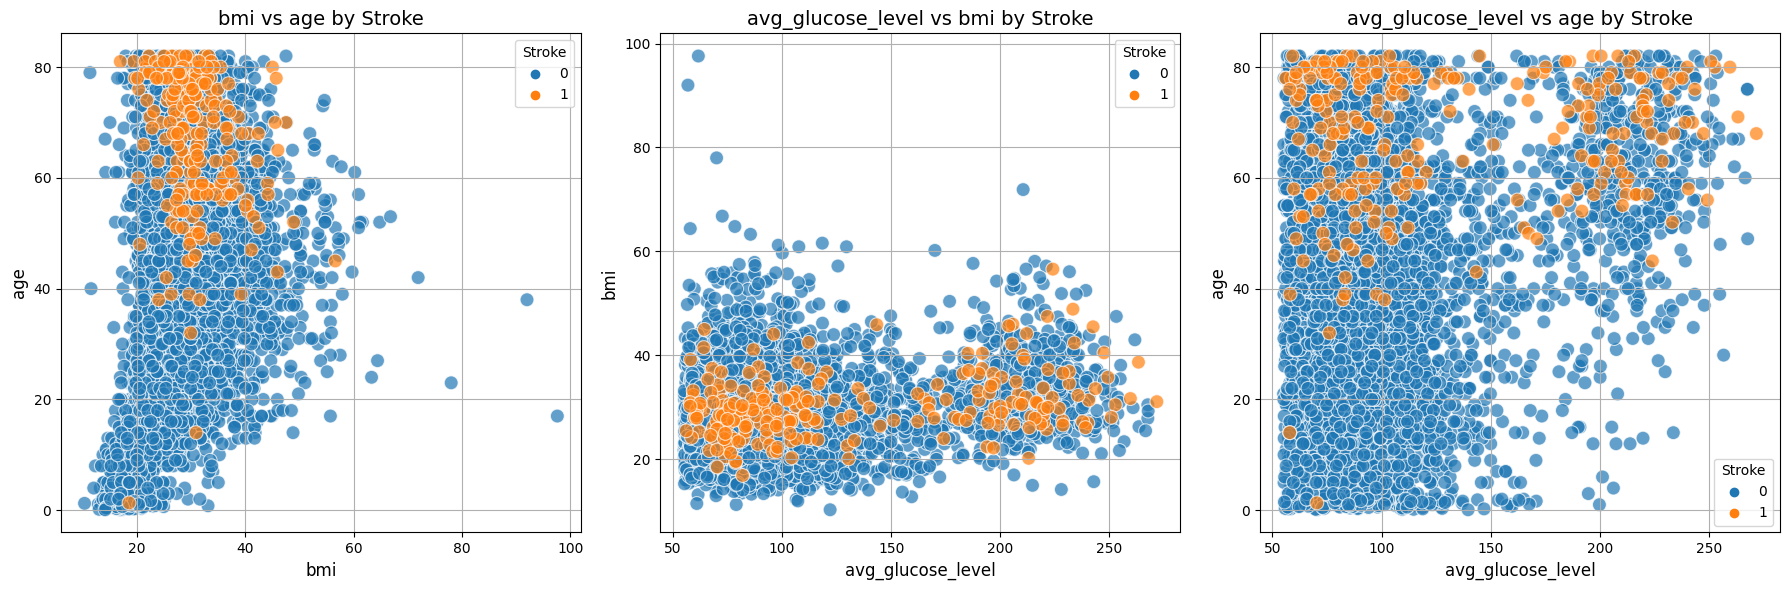

In [19]:
# Sort the DataFrame to place stroke=1 entries last (drawn on top)
df_raw_sorted = df_raw.sort_values(by='stroke')

# Create subplots for all combinations of 'age', 'avg_glucose_level', 'bmi'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Variable combinations - (x-axis, y-axis)
var_combinations = [('bmi', 'age'), ('avg_glucose_level','bmi'), ('avg_glucose_level','age')]

for i, (x_var, y_var) in enumerate(var_combinations):
    sns.scatterplot(
        data=df_raw_sorted,
        x=x_var,
        y=y_var,
        hue='stroke',
        alpha=0.7,
        s=100,
        ax=axes[i]
    )
    axes[i].set_title(f'{x_var} vs {y_var} by Stroke', fontsize=14)
    axes[i].set_xlabel(x_var, fontsize=12)
    axes[i].set_ylabel(y_var, fontsize=12)
    axes[i].grid(True)
    axes[i].legend(title='Stroke', fontsize=10)

plt.tight_layout()
plt.show()


Again reiterating on the same fact that age is clearly way more important than avg_glucose_level and bmi. However these graphs do some kind of a relationship between bmi and glucose_level as you can see that both bmi and glucose when low and when high have more chances of stroke. Chances of stroke thin out in the middle region of the second plot.

Lets move on to categorical features now 

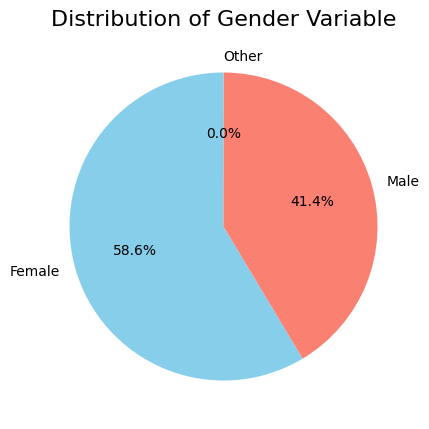

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64


In [20]:
# gender
gender_dist = df_raw["gender"].value_counts()

plt.figure(figsize=(6, 5))
gender_dist.plot.pie(autopct='%1.1f%%', startangle=90, labels=gender_dist.index, colors=['skyblue', 'salmon'])
plt.title('Distribution of Gender Variable', fontsize=16)
plt.ylabel('')  
plt.show()

print(gender_dist)

<Figure size 500x400 with 0 Axes>

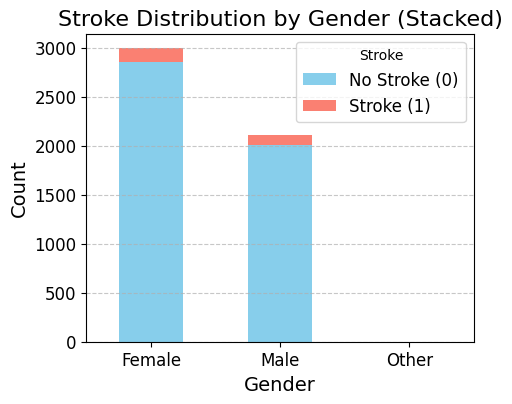

In [21]:
# Calculate the count of each stroke value per gender
gender_stroke_counts = df_raw.groupby(['gender', 'stroke']).size().unstack(fill_value=0)

# Plot stacked bar chart
plt.figure(figsize=(5, 4))
gender_stroke_counts.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], figsize=(5, 4))

# Add titles and labels
plt.title('Stroke Distribution by Gender (Stacked)', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(['No Stroke (0)', 'Stroke (1)'], title='Stroke', fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

We can say that gender doesnt seem to be a contributing factor to stroke since the distributions are quite similar. This should probably show up when we are doing a correlation heatmap later on. 

In [22]:
no_stroke = df_raw[df_raw['stroke'] == 0]
only_stroke = df_raw[df_raw['stroke'] == 1]

In [23]:
def bivariate_analysis(column_name, ax):
    # Calculate counts for stroke = 1
    positive = only_stroke[column_name].value_counts().reset_index()
    positive.columns = [column_name, "count"]  
    positive["Percentage"] = positive["count"] / positive["count"].sum() * 100
    
    # Calculate counts for stroke = 0
    negative = no_stroke[column_name].value_counts().reset_index()
    negative.columns = [column_name, "count"]  
    negative["Percentage"] = negative["count"] / negative["count"].sum() * 100
    
    # Plot horizontal bar chart on the provided axis
    ax.barh(positive[column_name], positive["Percentage"], color="teal", label='Stroke = 1', height=0.7)
    ax.barh(negative[column_name], negative["Percentage"], color="blue", label='Stroke = 0', height=0.3)
    
    # Format x-axis as percentage
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
    
    # Add titles and labels
    ax.set_title(f"{column_name} Distribution by Stroke", fontsize=10)
    ax.set_xlabel('Percentage', fontsize=8)
    ax.set_ylabel(column_name, fontsize=8)
    ax.legend(title='Stroke Status', fontsize=8, loc='upper right')
    
    # Add grid
    ax.grid(axis='x', linestyle='--', alpha=0.6, zorder=0)


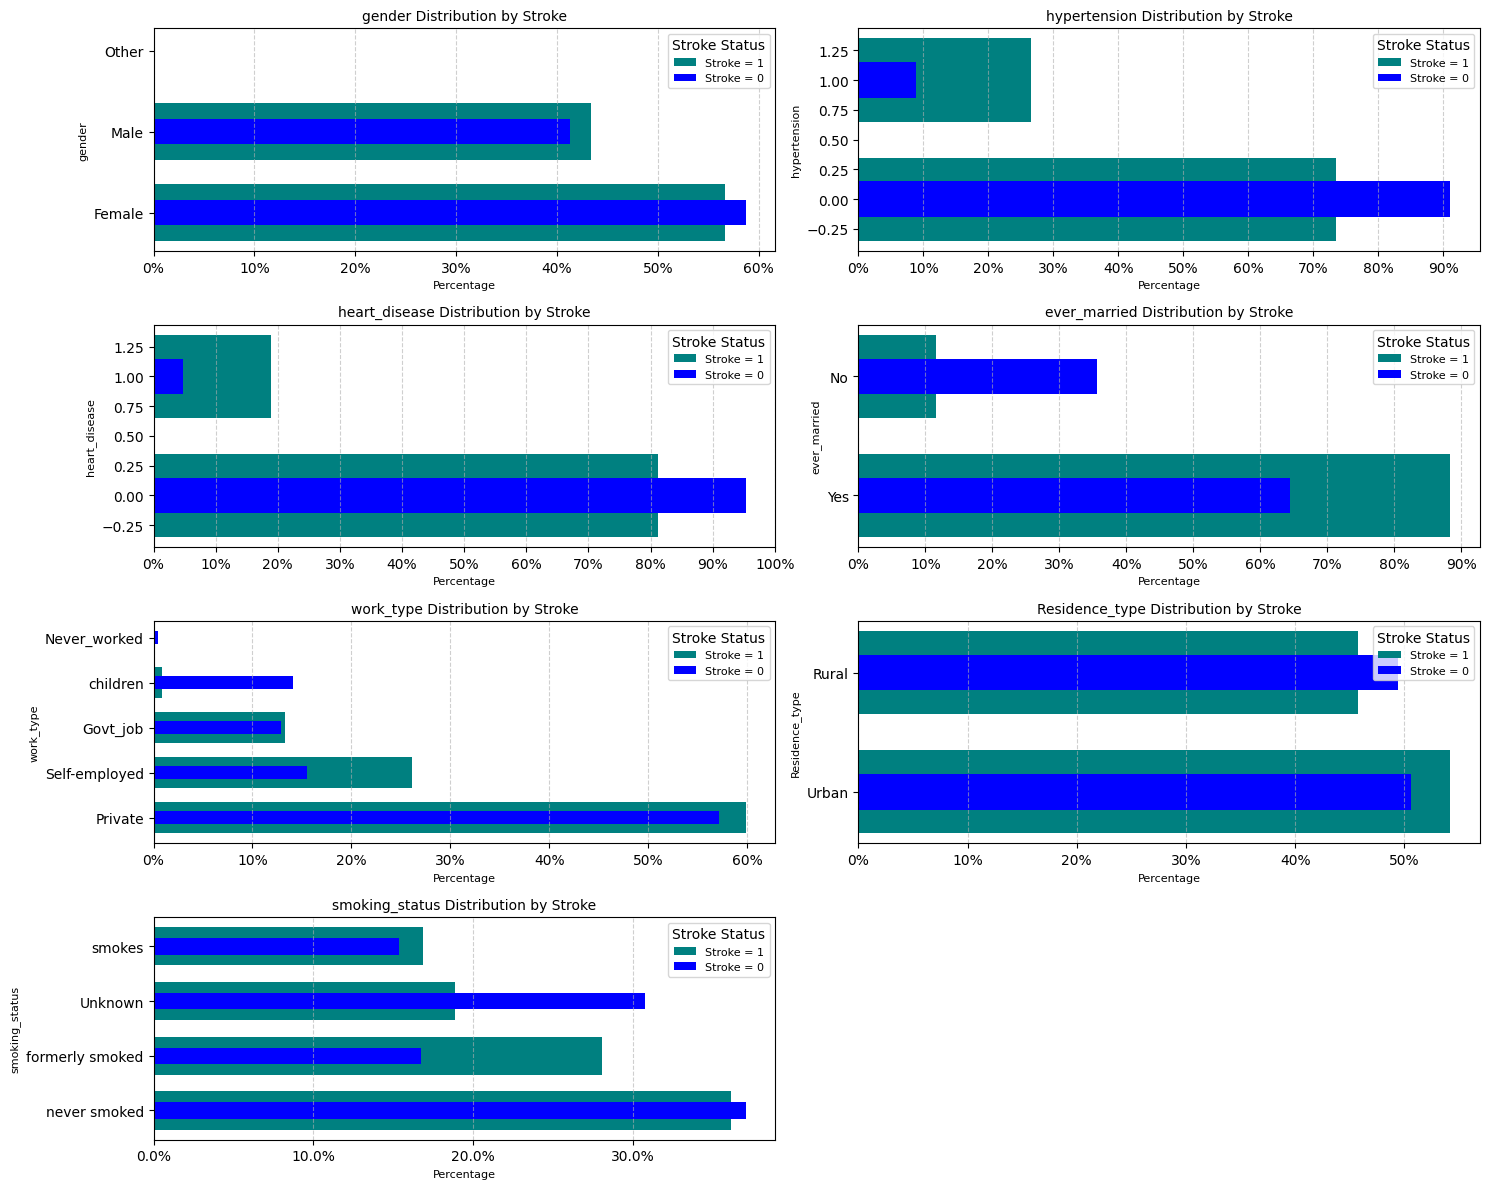

In [24]:
plt.figure(figsize=(15, 12))  

for i, var in enumerate(cat_vars, 1):
    plt.subplot(4, 2, i)  
    ax = plt.gca()
    bivariate_analysis(var, ax)

plt.tight_layout()
plt.show()

### Inference: 

Quite a lot of inferences here. Lets go one by one. 
- **Gender** : Men seem to be more prone to stroke. But the difference is not big enough to conclude anything.
- **Hypertension** : We can clearly see that people with hypertension = 1 is clearly more prone to strokes.
- **heart_disease** : People with heart disease = 1 is more prone to stroke. Kind of a no brainer.
- **ever_married** : According to this married people seem to be more prone to strokes. XD
- **work_type** : Children barely ever get strokes. Cant say much about private jobs. But self employed people have had more strokes (relatively)
- **Residence_type** : Urban people have had a relatively more strokes in comparison to rural. But again the difference isnt huge so it might be a sampling issue. Cant draw any strong conclusions here.
- **smoking_status** : This one is a bit weird. Its surprising that people who smoke currently have near about equal distrbution of strokes and no strokes. But in the group of formerly smoked, we see a considerable difference between strokes and no strokes with chances of strokes being much higher. This is a bit difficult to understand. We would have to do a detailed multivariate analysis with other features like age, heart_disease, work_type etc to actually draw a proper answer to this question

## Hypothesis Testing

Ok maybe I am over complicating at this point, but I am very curious about the smoking_status feature. I have a strong intuition that smoking_status is a confounding variable and it has different distribution of other variables (like age, bmi etc) across the different smoking groups. For example - It could be possible that most of the former smokers have higher age which is the primary reason for the strokes, not the fact that they are former smokers. 

If this comes out to be true, we might have to either do some kind of dimensionality reduction with PCA (i dont want to get into that) or merge smoking groups with other variables and not keep it as an independent feature (I like this much better).

Hence lets do a **Hypothesis Testing **

- Null Hypothesis (H₀): There is no difference in the distribution of these variables between smoking groups.
  
- Alternative Hypothesis (H₁): There is a significant difference in the distributions.

In [25]:
df_raw.smoking_status.value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

In [26]:
# Define groups
group_smokes = df_raw[df_raw['smoking_status'] == 'smokes']
group_formerly_smoked = df_raw[df_raw['smoking_status'] == 'formerly smoked']
group_never_smoked = df_raw[df_raw['smoking_status'] == 'never smoked']
group_unknown = df_raw[df_raw['smoking_status'] == 'Unknown']

In [27]:
#running Shapiro-Wilk test 
# Test normality for 'age' in each group
for group, name in zip([group_smokes, group_formerly_smoked, group_never_smoked, group_unknown], 
                        ['smokes', 'formerly smoked', 'never smoked', 'Unknown']):
    stat, p = stats.shapiro(group['age'])
    print(f"{name}: p-value = {p:.4f} {'(Normal)' if p > 0.05 else '(Not Normal)'}")

smokes: p-value = 0.0000 (Not Normal)
formerly smoked: p-value = 0.0000 (Not Normal)
never smoked: p-value = 0.0000 (Not Normal)
Unknown: p-value = 0.0000 (Not Normal)


Since the feature is NOT Normal we cannot use **ANOVA**. Instead we will use **Kruskal-Wallis**.

In [28]:
# Kruskal-Wallis Test to compare age across the groups
stat, p = stats.kruskal(group_smokes['age'], group_formerly_smoked['age'], 
                        group_never_smoked['age'], group_unknown['age'])
print(f"Kruskal-Wallis Test p-value = {p:.4f} {'(Significant)' if p < 0.05 else '(Not Significant)'}")

Kruskal-Wallis Test p-value = 0.0000 (Significant)


Since the Kruskal-Wallis Test p-value is 0.0000, it indicates that there are significant differences in the distribution of age across the different smoking groups (smokes, formerly smoked, never smoked, and unknown). This means that at least one of the smoking groups has a different distribution of age compared to the others. **Hence Null Hypothesis is Rejected.**

In [29]:


# Create a DataFrame with 'age' and 'smoking_status' columns
data_all = pd.concat([group_smokes['age'], group_formerly_smoked['age'], 
                      group_never_smoked['age'], group_unknown['age']], axis=0)
labels = ['smokes']*len(group_smokes) + ['formerly smoked']*len(group_formerly_smoked) + \
         ['never smoked']*len(group_never_smoked) + ['Unknown']*len(group_unknown)

# Combine data into a DataFrame
df_combined = pd.DataFrame({'age': data_all, 'smoking_status': labels})

# Perform Dunn's Test with Bonferroni correction
posthoc_result = posthoc_dunn(df_combined, val_col='age', group_col='smoking_status', p_adjust='bonferroni')

# Print the result
print(posthoc_result)

                       Unknown  formerly smoked  never smoked        smokes
Unknown           1.000000e+00    2.042780e-137  3.932805e-85  2.517199e-54
formerly smoked  2.042780e-137     1.000000e+00  4.619050e-20  2.184769e-13
never smoked      3.932805e-85     4.619050e-20  1.000000e+00  1.000000e+00
smokes            2.517199e-54     2.184769e-13  1.000000e+00  1.000000e+00


OK I did a lot of tests. Some of them I have never heard of before, like the Dunn test. But to explain simply :
We know that null hypothesis is rejected after kruskal-willis but we dont know which group inside smoking_status is the problem group. For that we are doing the Dunn Test. 

We will interpret the above results as follows : 

- **Unknown vs Formerly smoked**: The p-value is extremely small (2.042780e-137), which indicates a very significant difference between the Unknown and Formerly smoked groups.

- **Never smoked vs Smokes**: The p-value is 1.000000e+00, meaning there is no significant difference between the Never smoked and Smokes groups, at least in terms of the age distribution.

- **Smokes vs Formerly smoked**: The p-value (2.184769e-13) is very small, suggesting a significant difference between these two groups.

Note : the unkown group in general has very different distribution from all the other 3 groups followed by formerly smoked. This is enough to conclude that smoking_status is pretty much acting as a counfounfing variable.

Big question now - 

**What is a Confounding Variable?**
A confounding variable is one that:
Affects both the independent variable (predictor) and the dependent variable (outcome).
Its effect can distort or bias the relationship between the independent and dependent variables.

Why Keep the Confounder?

To better understand this, consider a simple analogy:

Without adjusting for smoking_status: You might find a strong relationship between age and stroke, but this relationship could be influenced by the fact that smokers (who might be younger) are also at risk of stroke.

With adjusting for smoking_status: Now, you can isolate the effect of age on stroke risk while controlling for smoking status (i.e., the model knows whether someone is a smoker, former smoker, or non-smoker and accounts for that in the prediction).




Before we finish off the EDA, lets create a final correlation heatmap including all features, just to finalise the decisions on whether we need to create interactions between multiple variables or not

In [30]:
df_raw.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.879487,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


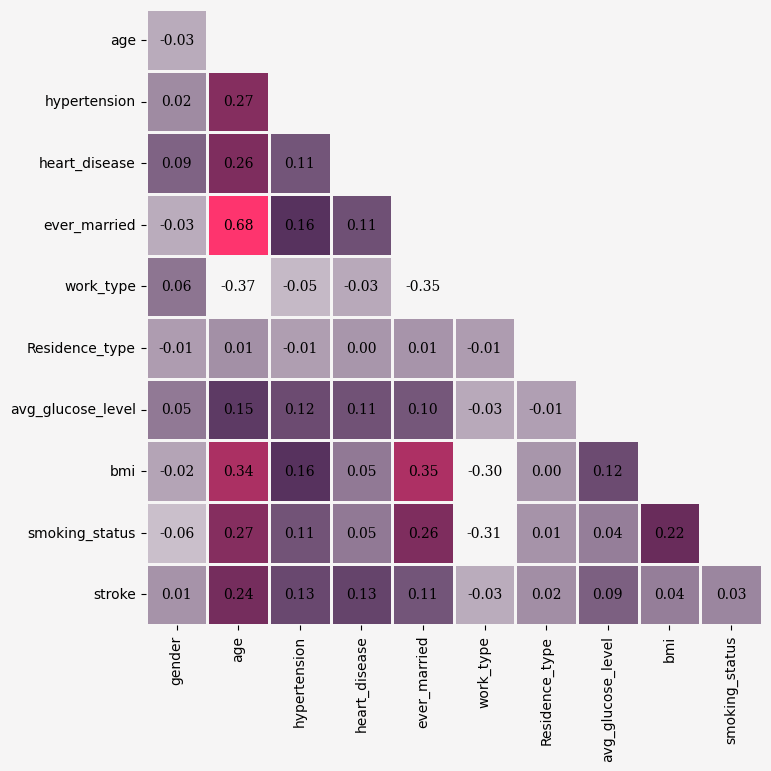

In [31]:
df_copy = df_raw.copy()
# feature log transformations 

df_copy['age'] = df_copy['age'].apply(lambda x: np.log(x+10)*3)
df_copy['avg_glucose_level'] = df_copy['avg_glucose_level'].apply(lambda x: np.log(x+10)*2)
df_copy['bmi'] = df_copy['bmi'].apply(lambda x: np.log(x+10)*2)



# preprocessing - label enconding and numerical value scaling
ohe = OneHotEncoder()
le = LabelEncoder()

## label encoding of ordinal categorical features
for col in df_copy.columns:
    df_copy[col] = le.fit_transform(df_copy[col])
    
cols = df_copy.columns


# correlation map for all the features
df_corr = df_copy.corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool))

fig, ax = plt.subplots(figsize = (8,8))
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()


colors = ['#f6f5f5','#512b58','#fe346e']
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",cmap = colormap,
           vmin=-0.15, vmax=0.5, cbar_kws={"shrink": .5, }, ax = ax, cbar = False,
           linewidth = 1,linecolor = '#f6f5f5', square = True,annot_kws = {'font':'serif', 'size':10, 'color':'black'} )
# yticks
ax.tick_params(axis = 'y', rotation=0)
xticks = ['Gender', 'Age','Hyper tension', 'Heart Disease', 'Marriage', 'Work', 'Residence', 'Glucose Level', 'BMI', 'Smoking Status','Stroke','BMI Cat','Age Cat']
yticks = ['Gender', 'Age','Hyper tension', 'Heart Disease', 'Marriage', 'Work', 'Residence', 'Glucose Level', 'BMI', 'Smoking Status','Stroke','BMI Cat','Age Cat']


fig.show()

A few key observations from the above heatmap:

1. Age is ofc the most prominant predictor of strokes.
2. Gender barely has any predicting capabilities. I am just gonna drop it.
3. ever_married is interesting. We see the bright pink color showing that ever_married is highly correlated with age. Which basically means the more your age the more the chances of you being married. Now remember we found that married people have significant more strokes. This is basically because of its strong relation with age and not because of marriage itself. Hence I am gonna drop this too.


I have decided to do data prep, baselining and stacking in a new notebook. So lets end this notebook here with just extensive EDA. 

############################### The End ###############################